*AI TRIP PLANNER*

In [ ]:
pip install langchain langchain_core langchain_groq langchain_community langchain langgraph


In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

DEFINE AGENT

In [ ]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage],"the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

API intergration

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
  temperature = 0,
  groq_api_key = "",
  model_name = "llama-3.3-70b-versatile"
)

"A multi-agent system (MAS) is a system that consists of multiple autonomous agents that interact with each other and their environment to achieve common or individual goals. These agents can be software programs, robots, or even humans, and they can be designed to work together, compete, or cooperate to solve complex problems.\n\nIn a multi-agent system, each agent has its own:\n\n1. **Autonomy**: Agents can make decisions and act independently, based on their own goals, knowledge, and capabilities.\n2. **Local view**: Agents have a limited view of the environment and other agents, and they must use this information to make decisions.\n3. **Interactions**: Agents can interact with each other through communication, cooperation, or competition.\n4. **Goals**: Agents have their own goals, which may be aligned or conflicting with the goals of other agents.\n\nMulti-agent systems can be used to model and solve a wide range of complex problems, such as:\n\n1. **Traffic management**: Multipl

In [ ]:
itinerary_prompt = ChatPromptTemplate.from_messages([
("system, You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
("human", "Create an itinerary for my day trip."),
])

Define agent function

In [ ]:
def input_city(state: PlannerState) -> PlannerState:
    """
    Collects the city name from the user and updates the state
    """
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your Input: ")

    return {
        **state,
        "city": user_message,
        "messages": state["messages"] + [HumanMessage(content=user_message)]
    }


def input_interest(state: PlannerState) -> PlannerState:
    """
    Collects user interests and updates the state
    """
    print(
        f"Please enter your interests for the trip to {state['city']} "
        "(comma-separated):"
    )
    user_message = input("Your Input: ")

    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state["messages"] + [HumanMessage(content=user_message)]
    }


def create_itinerary(state: PlannerState) -> PlannerState:
    """
    Generates the travel itinerary using the LLM
    """
    print(
        f"\nCreating an itinerary for {state['city']} "
        f"based on interests: {', '.join(state['interests'])}"
    )

    response = llm.invoke(
        itinerary_prompt.format_messages(
            city=state["city"],
            interests=", ".join(state["interests"])
        )
    )

    print("\nFinal Itinerary:\n")
    print(response.content)

    return {
        **state,
        "itinerary": response.content,
        "messages": state["messages"] + [AIMessage(content=response.content)]
    }


create and compile the graph


In [ ]:
# ===================== CREATE THE WORKFLOW =====================

# Initialize the state graph with the PlannerState
workflow = StateGraph(PlannerState)

# ===================== ADD NODES =====================

# Each node represents one step in the agent workflow
workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

# ===================== SET ENTRY POINT =====================

# This is the first node that will run
workflow.set_entry_point("input_city")

# ===================== DEFINE EDGES (FLOW) =====================

# Define the order of execution
workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# ===================== COMPILE THE GRAPH =====================

# Compile the workflow into an executable app
app = workflow.compile()


Display the graph


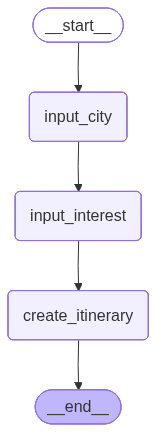

In [ ]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

# Display the LangGraph workflow as a diagram
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


Define function that runs the graph

In [ ]:
def travel_planner(user_request: str):
    """
    Runs the LangGraph workflow for the travel planner
    """
    print(f"Initial Request: {user_request}\n")

    # Initial state passed into the graph
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Execute the workflow (stream executes each node step-by-step)
    for _ in app.stream(state):
        pass


In [ ]:
user_request = "i want to plan a day trip "
travel_planner(user_request)

Initial Request: i want to plan a trip to goa

Please enter the city you want to visit for your day trip:
Your Input: goa
Please enter your interests for the trip to goa (comma-separated):
Your Input: beach , nature, water sports

Creating an itinerary for goa based on interests: beach, nature, water sports

Final Itinerary:

Here's a day trip itinerary for Goa based on your interests in beach, nature, and water sports:

* 9:00 AM - 10:00 AM: Start the day with a visit to **Baga Beach**, where you can relax and enjoy the sun, sand, and sea.
* 10:00 AM - 12:00 PM: Head to **Candolim Beach** for some exciting **water sports** like parasailing, jet-skiing, or kayaking.
* 12:00 PM - 1:30 PM: Take a break for lunch at a nearby restaurant and try some local Goan cuisine.
* 2:00 PM - 4:00 PM: Explore the **Salcette Mangrove Forest**, a unique and fascinating ecosystem that's home to a variety of flora and fauna.
* 4:30 PM - 6:00 PM: End the day with a visit to **Calangute Beach**, where you c

In [ ]:
!pip install gradio

UI

In [ ]:
# ===================== IMPORTS =====================
import gradio as gr
from typing import TypedDict, Annotated, List

from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq


# ===================== STATE DEFINITION =====================
class PlannerState(TypedDict):
    """
    Stores the planner state throughout execution
    """
    messages: Annotated[List[HumanMessage | AIMessage], "Conversation messages"]
    city: str
    interests: List[str]
    itinerary: str


# ===================== LLM SETUP =====================
llm = ChatGroq(
    temperature=0,
    groq_api_key="",
    model_name="llama-3.3-70b-versatile"
)


# ===================== PROMPT =====================
itinerary_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful travel assistant. "
        "Create a day trip itinerary for {city} based on the user's interests: {interests}. "
        "Provide a brief, bulleted itinerary."
    ),
    ("human", "Create an itinerary for my day trip.")
])


# ===================== STATE UPDATE FUNCTIONS =====================
def input_city(city: str, state: PlannerState) -> PlannerState:
    """
    Updates state with city input
    """
    return {
        **state,
        "city": city,
        "messages": state["messages"] + [HumanMessage(content=city)],
    }


def input_interests(interests: str, state: PlannerState) -> PlannerState:
    """
    Updates state with interests input
    """
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(",")],
        "messages": state["messages"] + [HumanMessage(content=interests)],
    }


def create_itinerary(state: PlannerState) -> str:
    """
    Generates itinerary using the LLM
    """
    response = llm.invoke(
        itinerary_prompt.format_messages(
            city=state["city"],
            interests=", ".join(state["interests"])
        )
    )

    state["itinerary"] = response.content
    state["messages"].append(AIMessage(content=response.content))

    return response.content


# ===================== MAIN PLANNER FUNCTION =====================
def travel_planner(city: str, interests: str) -> str:
    """
    Main function called by Gradio UI
    """
    # Initialize state
    state: PlannerState = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Update state step-by-step
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate itinerary
    return create_itinerary(state)


# ===================== GRADIO UI =====================
interface = gr.Interface(
    fn=travel_planner,
    theme="Yntec/HaleyCH_Theme_Orange_Green",
    inputs=[
        gr.Textbox(
            label="Enter the city for your day trip",
            placeholder="e.g., Nashik"
        ),
        gr.Textbox(
            label="Enter your interests (comma-separated)",
            placeholder="temples, trekking, food"
        ),
    ],
    outputs=gr.Textbox(
        label="Generated Itinerary",
        lines=15,
        max_lines=40,
        interactive=False
    ),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)


# ===================== RUN APP =====================
interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b6b49075f163445e55.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
